In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv


import other libraries

In [2]:
!pip install mord

  Preparing metadata (setup.py) ... - done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9886 sha256=b3978cdb6b80cf414cc310f821cf2cf5d034ed32768d5ed01ac1580a1ce9d6b1
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord


In [3]:
!pip install textatistic

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for textatistic: filename=textatistic-0.0.1-py3-none-any.whl size=29047 sha256=deedbe5dcd9fefccaf754bf9579ad520ae9684eabf69c73b709c3a22ea5d9291
  Stored in directory: /root/.cache/pip/wheels/6e/31/c3/df8af4aa9ec3f671b0e8bc3bfa642c75918f2479ca4050f5f4
  Created wheel for pyhyphen: filename=PyHyphen-4.0.3-cp37-abi3-linux_x86_64.whl size=37431 sha256=44187f751fc1ac1f628113f223b68b43740698a37bc52664f69808bfa81bcdd7
  Stored in directory: /root/.cache/pip/wheels/5e/8e/2c/099292ddfe67d4168785f44109ee79131c652ee5bdd66502b8
Successfully built textatistic pyhyphen


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, classification_report, accuracy_score, confusion_matrix
import re
from sklearn.pipeline import Pipeline
# from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from gensim.models import Word2Vec
from mord import OrdinalRidge
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

from textatistic import Textatistic
# import statsmodels.api as sm
# from statsmodels.miscmodels.ordinal_model import OrderedModel

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


****Read in the dataset

In [5]:
df_train = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
df_test = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
df_sub = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv')

# data cleaning


text cleaning functions to call on full_text

In [6]:
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\xa0"," ",phrase)
    return phrase.strip()

def clean_text(x):
    # Convert words to lowercase
    x = x.lower()
    # Remove HTML
    x = removeHTML(x)
    # Delete strings starting with @
    x = re.sub("@\w+", '',x)
    # Delete Numbers
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    # Delete URL
    x = re.sub("http\w+", '',x)
    # Replace consecutive empty spaces with a single space character
    x = re.sub(r"\s+", " ", x)
    # Replace consecutive commas and periods with one comma and period character
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    # Remove empty characters at the beginning and end
    x = x.strip()
    return decontracted(x)

In [7]:
df_train['full_text'] = df_train['full_text'].apply(clean_text)
df_test['full_text'] = df_test['full_text'].apply(clean_text)


In [8]:
df_train['full_text'][0]

'many people have car where they live. the thing they do not know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in vauban,germany they dont have that proble because percent of vauban is families do not own cars,and percent sold a car to move there. street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the french and swiss borders. you probaly will not see a car in vauban is streets because they are completely "car free" but if some that lives in vauban that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $, along with a home. the vauban people completed this in ,they said that this an example of a growing trend in europe,the untile states and some where else are suburba

# feature extraction 

create a word_count and text length column

In [9]:
df_train['word_count'] = df_train["full_text"].str.split().str.len()
df_test['word_count'] = df_test["full_text"].str.split().str.len()

In [10]:
df_train['length'] = df_train["full_text"].str.len()
df_test['length'] = df_test["full_text"].str.len()

In [11]:
df_train.head()

,essay_id,full_text,score,word_count,length
0,000d118,many people have car where they live. the thin...,3,496,2647
1,000fe60,i am a scientist at nasa that is discussing th...,3,336,1668
2,001ab80,people always wish they had the same technolog...,4,553,3068
3,001bdc0,"we all heard about venus, the planet without a...",4,450,2679
4,002ba53,"dear, state senator this is a letter to argue ...",3,377,2188


**readability scores:**

Dale-Chall score - Word familiarity

Flesch Reading Ease score - Sentence length and word syllables

Flesch-Kincaid score - Sentence length and syllable count

Gunning Fog score - Word complexity and sentence length

SMOG score - Grammar, syntax, and word choice

first add a full stop to the end of each essay that does not have one or else Textatistic gives a division by zero error

In [12]:
def add_full_stop(text):
    if not text.strip().endswith('.'):
        text += '.'
    return text

In [13]:
df_train['full_text'] = df_train['full_text'].apply(add_full_stop)
df_test['full_text'] = df_test['full_text'].apply(add_full_stop)

get all the scores for the entire df at once rather than each individual score one at a time

***Note: This may take a while to run, roughly 10 minutes when I ran it***

In [14]:
scores = []

scores = df_train['full_text'].apply(lambda text: Textatistic(text))
scores

0        <textatistic.textatistic.Textatistic object at...
1        <textatistic.textatistic.Textatistic object at...
2        <textatistic.textatistic.Textatistic object at...
3        <textatistic.textatistic.Textatistic object at...
4        <textatistic.textatistic.Textatistic object at...
                               ...                        
17302    <textatistic.textatistic.Textatistic object at...
17303    <textatistic.textatistic.Textatistic object at...
17304    <textatistic.textatistic.Textatistic object at...
17305    <textatistic.textatistic.Textatistic object at...
17306    <textatistic.textatistic.Textatistic object at...
Name: full_text, Length: 17307, dtype: object

pull out all the scores

In [15]:
flesch_scores = []
fleschkincaid_scores = []
gunningfog_scores = []
smog_scores = []
dalechall_scores = []

for score in scores:
    flesch_scores.append(score.scores['flesch_score'])
    fleschkincaid_scores.append(score.scores['fleschkincaid_score'])
    gunningfog_scores.append(score.scores['gunningfog_score'])
    smog_scores.append(score.scores['smog_score'])
    dalechall_scores.append(score.scores['dalechall_score'])


add them to the dataframe

In [16]:
# df_train['flesch_score'] = [index for df_train.index]
df_train['flesch_score'] = flesch_scores
df_train['fleschkincaid_score'] = fleschkincaid_scores
df_train['gunningfog_score'] = gunningfog_scores
df_train['smog_score'] = smog_scores
df_train['dalechall_score'] = dalechall_scores

do same for test df

In [17]:
scores = []

scores = df_test['full_text'].apply(lambda text: Textatistic(text))


flesch_scores = []
fleschkincaid_scores = []
gunningfog_scores = []
smog_scores = []
dalechall_scores = []

for score in scores:
    flesch_scores.append(score.scores['flesch_score'])
    fleschkincaid_scores.append(score.scores['fleschkincaid_score'])
    gunningfog_scores.append(score.scores['gunningfog_score'])
    smog_scores.append(score.scores['smog_score'])
    dalechall_scores.append(score.scores['dalechall_score'])
    
df_test['flesch_score'] = flesch_scores
df_test['fleschkincaid_score'] = fleschkincaid_scores
df_test['gunningfog_score'] = gunningfog_scores
df_test['smog_score'] = smog_scores
df_test['dalechall_score'] = dalechall_scores

In [18]:
df_train.head()

,essay_id,full_text,score,word_count,length,flesch_score,fleschkincaid_score,gunningfog_score,smog_score,dalechall_score
0,000d118,many people have car where they live. the thin...,3,496,2647,63.456903,13.848623,17.062348,10.727763,8.366057
1,000fe60,i am a scientist at nasa that is discussing th...,3,336,1668,90.887857,4.557143,7.233333,6.427356,6.591826
2,001ab80,people always wish they had the same technolog...,4,553,3068,71.165344,9.067735,12.338026,10.775791,7.232589
3,001bdc0,"we all heard about venus, the planet without a...",4,450,2679,62.588389,9.817469,13.793928,12.704596,9.390415
4,002ba53,"dear, state senator this is a letter to argue ...",3,377,2188,59.907500,10.741489,13.442553,11.933033,8.875584


In [19]:
df_test.head()

,essay_id,full_text,word_count,length,flesch_score,fleschkincaid_score,gunningfog_score,smog_score,dalechall_score
0,000d118,many people have car where they live. the thin...,496,2647,63.456903,13.848623,17.062348,10.727763,8.366057
1,000fe60,i am a scientist at nasa that is discussing th...,336,1668,90.887857,4.557143,7.233333,6.427356,6.591826
2,001ab80,people always wish they had the same technolog...,553,3068,71.165344,9.067735,12.338026,10.775791,7.232589


this method trains and evaluates each pipeline 
returns the y_pred and quadratic weighted kappa score of the model

In [20]:
def train_and_evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
    
    print()
    print('Classifier used: ', pipeline.named_steps['classifier'])
    print('y_test: ', y_test.tolist()[0:10])
    print('y_pred: ', y_pred.tolist()[0:10])
    print('quadratic weighted kappa score: ', kappa)
    
    return pipeline, y_pred

method for performing cross_validation of pipelines and showing their average performances

In [21]:
#define quadratic weighted kappa as a custom scorer
qwk_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

def pipeline_cross_validation(pipeline, X_train, y_train, qwk_scorer=qwk_scorer):
    # Define cross-validation strategy and perform cross-validation
    scoring = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted', 'qwk': qwk_scorer}
    cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)

    # Print cross-validation results
    print("Mean Accuracy:", np.mean(cv_results['test_accuracy']))
    print("Mean Weighted F1-score:", np.mean(cv_results['test_f1_weighted']))
    print("Mean Quadratic Weighted Kappa Score:", np.mean(cv_results['test_qwk']))
    
#     return np.mean(cv_results['test_qwk']), np.mean(cv_results['test_accuracy']), np.mean(cv_results['test_f1_weighted'])
    return cv_results

method for printing wordcloud

In [22]:
def print_cloud(data):
    text = " ".join(word for word in data)
    print ("There are {} words in the combination".format(len(text)))
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(text)
    return wordcloud

show word cloud for full texts of essays

There are 35364218 words in the combination


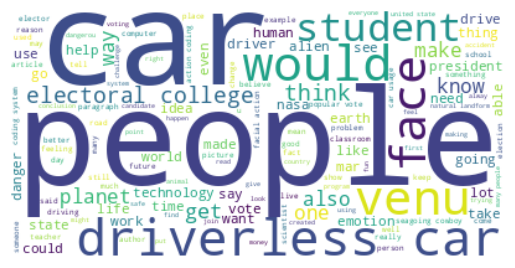

In [23]:
wordcloud = print_cloud(df_train['full_text'])
fig = plt.figure(2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

distribution of classes

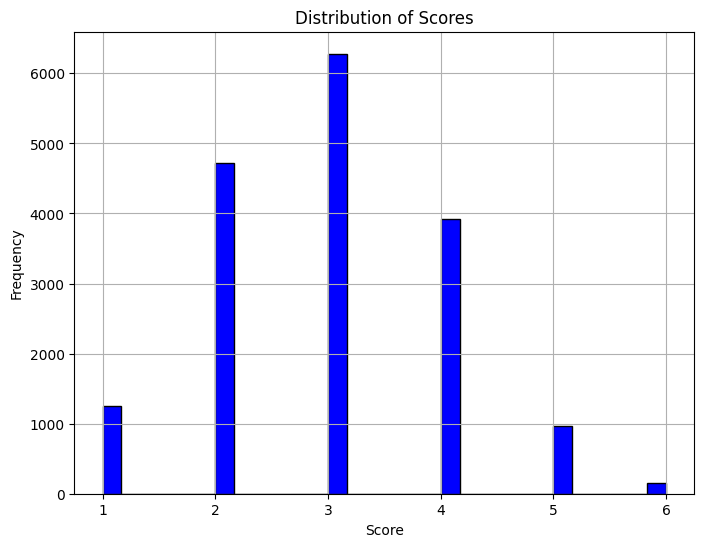

In [24]:
plt.figure(figsize=(8, 6))
plt.hist(df_train['score'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

create the tfidf

In [25]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=0.05, max_df=0.95,)

create the multinomial logistic regression classifier

In [26]:
logreg_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)

create preprocessor for pipelines

In [27]:
tfidf_preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfidf_vectorizer, 'full_text'),
        ('word_count', StandardScaler(), ['word_count']),
        ('length', StandardScaler(), ['length']),
        ('flesch_score', StandardScaler(), ['flesch_score']),
        ('fleschkincaid_score', StandardScaler(), ['fleschkincaid_score']),
        ('gunningfog_score', StandardScaler(), ['gunningfog_score']),
        ('smog_score', StandardScaler(), ['smog_score']),
        ('dalechall_score', StandardScaler(), ['dalechall_score'])
    ],
    remainder='passthrough'
)

pipeline for logistic regression

In [28]:
logreg_pipeline = Pipeline(steps=[
#     ('tfidf', tfidf_vectorizer),
    ('preprocessor', tfidf_preprocessor),
    ('classifier', logreg_clf)
])

# splitting X and y

In [29]:
X = df_train[['full_text', 'word_count', 'length', 'flesch_score' , 'fleschkincaid_score', 'gunningfog_score', 'smog_score', 'dalechall_score']]
y = df_train['score']
sub_X = df_test[['full_text', 'word_count', 'length', 'flesch_score' , 'fleschkincaid_score', 'gunningfog_score', 'smog_score', 'dalechall_score']]
sub_y = df_sub['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)



# training and evaluating models 

In [30]:
trained_logreg_pipeline, logreg_y_pred = train_and_evaluate_pipeline(logreg_pipeline, X_train, y_train, X_test, y_test)


Classifier used:  LogisticRegression(max_iter=500, multi_class='multinomial')
y_test:  [3, 2, 3, 3, 3, 3, 1, 2, 3, 2]
y_pred:  [3, 3, 3, 2, 3, 4, 2, 2, 3, 2]
quadratic weighted kappa score:  0.7300148595732716


run cross validation to get average performance

In [31]:
logreg_cv_results = pipeline_cross_validation(logreg_pipeline, X_train, y_train)
avg_logreg_qwk = np.mean(logreg_cv_results['test_qwk'])
avg_logreg_acc = np.mean(logreg_cv_results['test_accuracy'])
avg_logreg_f1 = np.mean(logreg_cv_results['test_f1_weighted'])

Mean Accuracy: 0.597327555074034
Mean Weighted F1-score: 0.5872595328015017
Mean Quadratic Weighted Kappa Score: 0.7273836012417305


In [32]:
print(classification_report(y_test, logreg_y_pred))

              precision    recall  f1-score   support

           1       0.63      0.27      0.38       255
           2       0.61      0.67      0.64       922
           3       0.57      0.65      0.61      1248
           4       0.56      0.55      0.56       798
           5       0.50      0.31      0.38       206
           6       0.50      0.15      0.23        33

    accuracy                           0.58      3462
   macro avg       0.56      0.43      0.47      3462
weighted avg       0.58      0.58      0.57      3462



In [33]:
print("Model prediction on submission essays: ", trained_logreg_pipeline.predict(sub_X).tolist())
print('Submission essays actual classes: ', sub_y.tolist())

Model prediction on submission essays:  [1, 3, 4]
Submission essays actual classes:  [3, 3, 4]


create a lightgbm model pipeline

lgbm over xgboost for performance and scalability? maybe elaborate more

In [34]:
lgbm_clf = LGBMClassifier(objective='multiclass', num_class=6, metric='multi_logloss', num_leaves=31, learning_rate=0.1, feature_fraction=0.6)

In [35]:
lgbm_pipeline = Pipeline(steps=[
#     ('tfidf', tfidf_vectorizer),   # TF-IDF Vectorizer
    ('preprocessor', tfidf_preprocessor),
    ('classifier', lgbm_clf) # LightGBM Classifier
])

use some GridSearchCV to find the best parameters

In [36]:
# parameter grid used for the grid search:
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'feature_fraction': [0.6, 0.8, 0.9]
}

In [37]:
trained_lgbm_pipeline, lgbm_y_pred = train_and_evaluate_pipeline(lgbm_pipeline, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113341
[LightGBM] [Info] Number of data points in the train set: 13845, number of used features: 447
[LightGBM] [Info] Start training from score -2.630929
[LightGBM] [Info] Start training from score -1.292660
[LightGBM] [Info] Start training from score -1.012107
[LightGBM] [Info] Start training from score -1.487530
[LightGBM] [Info] Start training from score -2.897112
[LightGBM] [Info] Start training from score -4.723495
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

Classifier 

In [38]:
lgbm_cv_results = pipeline_cross_validation(lgbm_pipeline, X_train, y_train)
avg_lgbm_qwk = np.mean(lgbm_cv_results['test_qwk'])
avg_lgbm_acc = np.mean(lgbm_cv_results['test_accuracy'])
avg_lgbm_f1 = np.mean(lgbm_cv_results['test_f1_weighted'])

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 108372
[LightGBM] [Info] Number of data points in the train set: 11076, number of used features: 448
[LightGBM] [Info] Start training from score -2.630427
[LightGBM] [Info] Start training from score -1.292923
[LightGBM] [Info] Start training from score -1.012007
[LightGBM] [Info] Start training from score -1.487690
[LightGBM] [Info] Start training from score -2.897439
[LightGBM] [Info] Start training from score -4.717416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_b

In [39]:
print(classification_report(y_test, lgbm_y_pred))

              precision    recall  f1-score   support

           1       0.66      0.34      0.45       255
           2       0.66      0.61      0.63       922
           3       0.57      0.64      0.60      1248
           4       0.56      0.62      0.59       798
           5       0.51      0.40      0.45       206
           6       0.56      0.30      0.39        33

    accuracy                           0.59      3462
   macro avg       0.59      0.49      0.52      3462
weighted avg       0.59      0.59      0.58      3462



In [40]:
print("Model prediction on submission essays: ", trained_lgbm_pipeline.predict(sub_X).tolist())
print('Submission essays actual classes: ', sub_y.tolist())

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Model prediction on submission essays:  [3, 3, 4]
Submission essays actual classes:  [3, 3, 4]


ordinal logistic regression classsifier

In [41]:
ordreg_clf = OrdinalRidge()

In [42]:
ordreg_pipeline = Pipeline(steps=[
    ('preprocessor', tfidf_preprocessor),
    ('classifier', ordreg_clf) # ordinal regression Classifier
])

In [43]:
trained_ordreg_pipeline, ordreg_y_pred = train_and_evaluate_pipeline(ordreg_pipeline, X_train, y_train, X_test, y_test)


Classifier used:  OrdinalRidge()
y_test:  [3, 2, 3, 3, 3, 3, 1, 2, 3, 2]
y_pred:  [3.0, 3.0, 3.0, 2.0, 3.0, 4.0, 2.0, 3.0, 3.0, 2.0]
quadratic weighted kappa score:  0.7330735936828482


In [44]:
print(classification_report(y_test, ordreg_y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.65      0.22      0.33       255
         2.0       0.60      0.64      0.62       922
         3.0       0.56      0.71      0.62      1248
         4.0       0.59      0.48      0.53       798
         5.0       0.47      0.31      0.37       206
         6.0       0.30      0.27      0.29        33

    accuracy                           0.57      3462
   macro avg       0.45      0.38      0.39      3462
weighted avg       0.58      0.57      0.56      3462



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
print("Model prediction on submission essays: ", trained_ordreg_pipeline.predict(sub_X).tolist())
print('Submission essays actual classes: ', sub_y.tolist())

Model prediction on submission essays:  [2.0, 3.0, 4.0]
Submission essays actual classes:  [3, 3, 4]


In [46]:
ordreg_cv_results = pipeline_cross_validation(ordreg_pipeline, X_train, y_train)
avg_ordreg_qwk = np.mean(ordreg_cv_results['test_qwk'])
avg_ordreg_acc = np.mean(ordreg_cv_results['test_accuracy'])
avg_ordreg_f1 = np.mean(ordreg_cv_results['test_f1_weighted'])

Mean Accuracy: 0.5901047309498015
Mean Weighted F1-score: 0.5789203363713478
Mean Quadratic Weighted Kappa Score: 0.7416075415676262


Random Forest Classifier 

In [47]:
rf_clf = RandomForestClassifier()

In [48]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', tfidf_preprocessor),
    ('classifier', rf_clf) # randomforest Classifier
])

In [49]:
trained_rf_pipeline, rf_y_pred = train_and_evaluate_pipeline(rf_pipeline, X_train, y_train, X_test, y_test)


Classifier used:  RandomForestClassifier()
y_test:  [3, 2, 3, 3, 3, 3, 1, 2, 3, 2]
y_pred:  [3, 4, 3, 3, 4, 4, 3, 2, 3, 2]
quadratic weighted kappa score:  0.6638379724248054


In [50]:
rf_cv_results = pipeline_cross_validation(rf_pipeline, X_train, y_train)
avg_rf_qwk = np.mean(rf_cv_results['test_qwk'])
avg_rf_acc = np.mean(rf_cv_results['test_accuracy'])
avg_rf_f1 = np.mean(rf_cv_results['test_f1_weighted'])

Mean Accuracy: 0.586710003611412
Mean Weighted F1-score: 0.5573243692096754
Mean Quadratic Weighted Kappa Score: 0.6798454865098437


In [51]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           1       0.71      0.10      0.17       255
           2       0.63      0.62      0.62       922
           3       0.54      0.68      0.61      1248
           4       0.53      0.60      0.56       798
           5       0.42      0.07      0.12       206
           6       0.00      0.00      0.00        33

    accuracy                           0.56      3462
   macro avg       0.47      0.35      0.35      3462
weighted avg       0.56      0.56      0.53      3462



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
print("Model prediction on submission essays: ", trained_rf_pipeline.predict(sub_X).tolist())
print('Submission essays actual classes: ', sub_y.tolist())

Model prediction on submission essays:  [3, 3, 4]
Submission essays actual classes:  [3, 3, 4]


MLP Classifier model and pipeline

In [53]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(150,100, 50), activation='relu', learning_rate='adaptive', max_iter=500)

In [54]:
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', tfidf_preprocessor),
    ('classifier', mlp_clf)
])

In [55]:
trained_mlp_pipeline, mlp_y_pred = train_and_evaluate_pipeline(mlp_pipeline, X_train, y_train, X_test, y_test)


Classifier used:  MLPClassifier(hidden_layer_sizes=(150, 100, 50), learning_rate='adaptive',
              max_iter=500)
y_test:  [3, 2, 3, 3, 3, 3, 1, 2, 3, 2]
y_pred:  [3, 3, 4, 1, 4, 3, 2, 2, 3, 2]
quadratic weighted kappa score:  0.7112599070474246


In [56]:
mlp_cv_results = pipeline_cross_validation(mlp_pipeline, X_train, y_train)

Mean Accuracy: 0.5569519682195738
Mean Weighted F1-score: 0.5560055201674288
Mean Quadratic Weighted Kappa Score: 0.7219227416528602


In [57]:
avg_mlp_qwk = np.mean(mlp_cv_results['test_qwk'])
avg_mlp_acc = np.mean(mlp_cv_results['test_accuracy'])
avg_mlp_f1 = np.mean(mlp_cv_results['test_f1_weighted'])

In [58]:
print("Model prediction on submission essays: ", trained_mlp_pipeline.predict(sub_X).tolist())
print('Submission essays actual classes: ', sub_y.tolist())

Model prediction on submission essays:  [3, 3, 4]
Submission essays actual classes:  [3, 3, 4]


# visualizations of performances

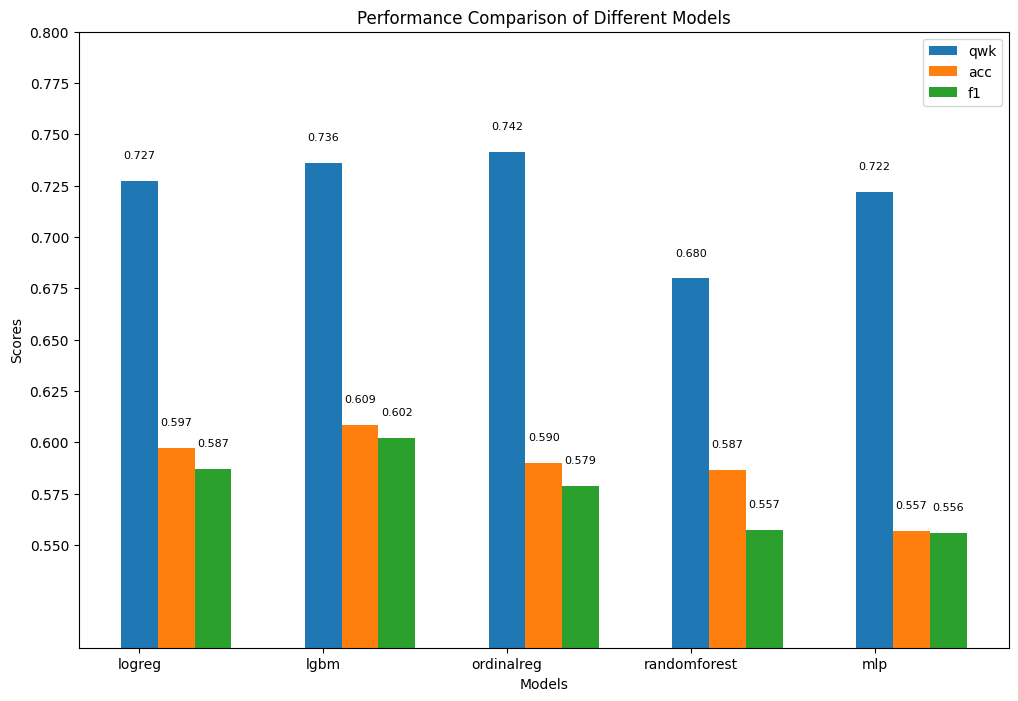

In [59]:
qwk_scores = [avg_logreg_qwk, avg_lgbm_qwk, avg_ordreg_qwk, avg_rf_qwk, avg_mlp_qwk]
acc_scores = [avg_logreg_acc, avg_lgbm_acc, avg_ordreg_acc, avg_rf_acc, avg_mlp_acc]
f1_scores = [avg_logreg_f1, avg_lgbm_f1, avg_ordreg_f1, avg_rf_f1, avg_mlp_f1]
model_names = ['logreg', 'lgbm', 'ordinalreg', 'randomforest', 'mlp']

plt.figure(figsize=(12, 8))

bar_width = 0.2

plt.bar([x for x in range(len(model_names))], qwk_scores, width=0.2, label='qwk')
plt.bar([x + bar_width for x in range(len(model_names))], acc_scores, width=0.2, label='acc')
plt.bar([x + bar_width + bar_width for x in range(len(model_names))], f1_scores, width=0.2, label='f1')



# Adding labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Performance Comparison of Different Models')
plt.ylim(0.5, 0.8) # this zoomes in the scale to make it easier to see
plt.xticks([x for x in range(len(model_names))], model_names)
plt.yticks([round(0.55 + 0.025 * i, 3) for i in range(11)]) # this makes the y axis show a better range of values

#  Annotate each bar with its value
for i, score in enumerate(qwk_scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom', color='black', fontsize=8)
for i, score in enumerate(acc_scores):
    plt.text(i + bar_width, score + 0.01, f'{score:.3f}', ha='center', va='bottom', color='black', fontsize=8)
for i, score in enumerate(f1_scores):
    plt.text(i + 2 * bar_width, score + 0.01, f'{score:.3f}', ha='center', va='bottom', color='black', fontsize=8)

plt.legend()

# Show plot
plt.show()

heatmap

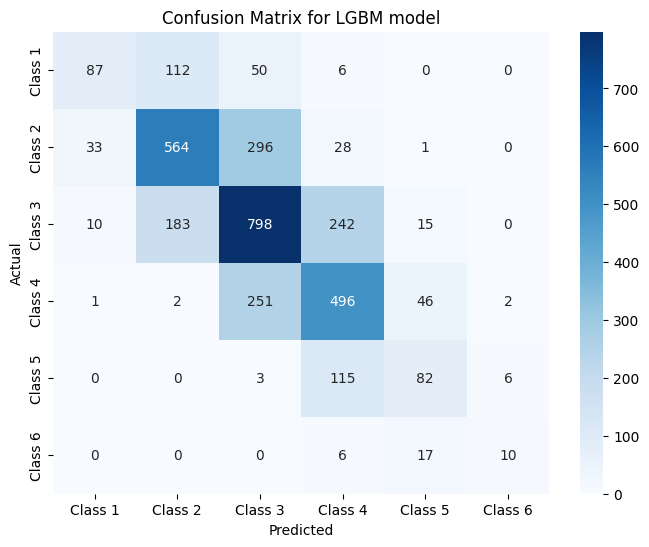

In [60]:
cm = confusion_matrix(y_test,lgbm_y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f"Class {i}" for i in range(1,7)], 
            yticklabels=[f"Class {i}" for i in range(1,7)])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for LGBM model")
plt.show()

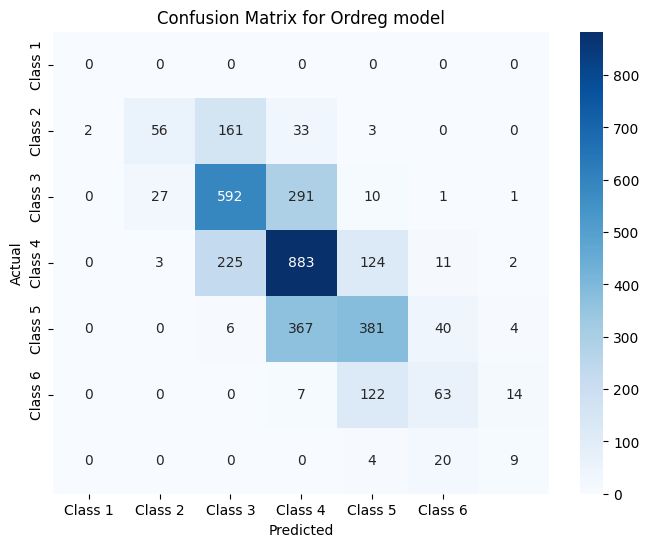

In [61]:
cm = confusion_matrix(y_test,ordreg_y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f"Class {i}" for i in range(1,7)], 
            yticklabels=[f"Class {i}" for i in range(1,7)])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Ordreg model")
plt.show()

# save the submission as a csv

In [62]:
df_sub['score'] = trained_lgbm_pipeline.predict(sub_X).tolist()
df_sub

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


In [63]:
df_sub.to_csv('submission.csv', index=None)